In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Imported Powerpoints/car-safety'    #project folder directory


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd 'gdrive/My Drive/Imported Powerpoints/car-safety'


/content/gdrive/My Drive/Imported Powerpoints/car-safety


In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
df_uk_accidents = pd.read_csv('data/uk_accidents.csv', encoding = 'unicode_escape')
df_uk_vehicles = pd.read_csv('data/uk_vehicles.csv', encoding = 'unicode_escape')
df_uk_casualties = pd.read_csv('data/uk_casualties.csv', encoding = 'unicode_escape')
df_uk_makes = pd.read_csv('data/Vehicle_Information.csv', usecols = [0, 10, 11, 19], encoding = 'unicode_escape')
df_ratings = pd.read_csv('all_ratings.csv') 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Appending makes and models to the UK vehicles DF
if 'Vehicle_Make' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_makes, on = ['Accident_Index', 'Vehicle_Reference'], how='left')
    
# Rename vehicle make, model to follow the same convention
df_uk_vehicles.rename(columns={'make': 'Vehicle_Make', 'model': 'Vehicle_Model'}, inplace = True)

# Mapping numeric values to corresponding text
df_uk_vehicles_map = {
    'Sex_of_Driver': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Age_Band_of_Driver': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'}, 
    'Vehicle_Make': {'MISSING': np.nan},
    'Vehicle_Model': {'MISSING': np.nan},
    'Age_of_Vehicle': {-1: np.nan},
    '1st_Point_of_Impact': {-1: np.nan, 1: 'Front', 2: 'Back', 3: 'Offside', 4: 'Nearside'},
    'Vehicle_Manoeuvre': {-1: np.nan, 1: 'Reversing', 2: 'Parked', 3: 'Waiting to go - held up', 4: 'Slowing or stopping', 5: 'Moving off', 6: 'U-turn', 7: 'Turning left', 8: 'Waiting to turn left', 9: 'Turning right', 10: 'Waiting to turn right', 11: 'Changing lane to left', 12: 'Changing lane to right', 13: 'Overtaking moving vehicle – offside', 14: 'Overtaking static vehicle - offside', 15: 'Overtaking - nearside', 16: 'Going ahead left-hand bend', 17: 'Going ahead right-hand bend', 18: 'Going ahead other'},
    'Vehicle_Type': {-1: np.nan, 90: np.nan, 1: 'Pedal cycle', 2: 'Motorcycle <=50cc', 3: 'Motorcycle <=125cc', 4: 'Motorcycle 125cc-500cc', 5: 'Motorcycle >500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8-16 seats)', 11: 'Bus (>=17 seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van <=3.5 t.', 20: 'Goods 3.5t.-7.5t', 21: 'Goods >=7.5 t.', 22: 'Mobility scooter', 23: 'Electric motorcycle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight'},
    'Vehicle_Location-Restricted_Lane': {-1: np.nan, 0: 'On main carriageway - not in restricted lane', 1: 'Tram/Light rail track', 2: 'Bus lane', 3:	'Busway (including guided busway)', 4: 'Cycle lane (on main carriageway)', 5: 'Cycleway or shared use footway (not part of  main carriageway)', 6: 'On lay-by or hard shoulder', 7:	'Entering lay-by or hard shoulder', 8:	'Leaving lay-by or hard shoulder', 9: 'Footway (pavement)', 10:	'Not on carriageway'},
    'Junction_Location': {-1: np.nan, 0: 'Not at or within 20 metres of junction', 1:	'Approaching junction or waiting/parked at junction approach', 2:	'Cleared junction or waiting/parked at junction exit', 3:	'Leaving roundabout', 4: 'Entering roundabout', 5: 'Leaving main road', 6: 'Entering main road', 7:	'Entering from slip road', 8:	'Mid Junction - on roundabout or on main road'},
    'Skidding_and_Overturning': {-1: np.nan, 0: 'None', 1: 'Skidded', 2: 'Skidded and overturned', 3:	'Jackknifed', 4: 'Jackknifed and overturned', 5: 'Overturned'},
    'Hit_Object_in_Carriageway': {-1: np.nan, 11: np.nan, 0: 'None', 1: 'Previous accident', 2: 'Road works', 4: 'Parked vehicle', 5:	'Bridge (roof)', 6:	'Bridge (side)', 7:	'Bollard or refuge', 8:	'Open door of vehicle', 9: 'Central island of roundabout', 10: 'Kerb', 12: 'Any animal (except ridden horse)'}, 
    'Vehicle_Leaving_Carriageway': {-1: np.nan, 0: 'Did not leave carriageway', 1: 'Nearside', 2:	'Nearside and rebounded', 3: 'Straight ahead at junction', 4: 'Offside on to central reservation', 5:	'Offside on to centrl res + rebounded', 6: 'Offside - crossed central reservation', 7: 'Offside', 8: 'Offside and rebounded'},
    'Hit_Object_off_Carriageway': {-1: np.nan, 10: np.nan, 0: 'None', 1: 'Road sign or traffic signal', 2: 'Lamp post', 3: 'Telegraph or electricity pole', 4: 'Tree', 5:	'Bus stop or bus shelter', 6:	'Central crash barrier', 7:	'Near/Offside crash barrier', 8: 'Submerged in water', 9: 'Entered ditch', 11: 'Wall or fence'},
    'Journey_Purpose_of_Driver' : {-1: np.nan, 5: np.nan, 6: np.nan, 15: np.nan, 1:	'Journey as part of work', 2:	'Commuting to/from work', 3: 'Taking pupil to/from school', 4: 'Pupil riding to/from school'},
    'Age_of_Driver': {-1: np.nan},
    'Engine_Capacity_(CC)': {-1: np.nan},
    'Propulsion_Code': {-1: np.nan, 1: 'Petrol', 2: 'Heavy oil', 3: 'Electric', 4:	'Steam', 5:	'Gas', 6:	'Petrol/Gas (LPG)', 7: 'Gas/Bi-fuel', 8: 'Hybrid electric', 9: 'Gas Diesel', 10: 'New fuel technology', 11:	'Fuel cells', 12:	'Electric diesel'},
    'Driver_Home_Area_Type': {-1: np.nan, 1: 'Urban area', 2:	'Small town', 3: 'Rural'}
}

df_uk_accidents_map = {
    'Accident_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Weather_Conditions': {-1: np.nan, 8: np.nan, 9: np.nan, 1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or mist'},
    'Light_Conditions': {-1: np.nan, 1: 'Daylight', 4: 'Darkness - lights lit', 5: 'Darkness - lights unlit', 6: 'Darkness - no lighting', 7: 'Darkness - lighting unknown'},
    'Police_Force': {1:	'Metropolitan Police', 3: 'Cumbria', 4:	'Lancashire', 5: 'Merseyside', 6:	'Greater Manchester', 7: 'Cheshire', 10: 'Northumbria', 11:	'Durham', 12:	'North Yorkshire', 13: 'West Yorkshire', 14: 'South Yorkshire', 16:	'Humberside', 17:	'Cleveland', 20: 'West Midlands', 21:	'Staffordshire', 22: 'West Mercia', 23:	'Warwickshire', 30: 'Derbyshire', 31:	'Nottinghamshire', 32: 'Lincolnshire', 33:	'Leicestershire', 34:	'Northamptonshire', 35:	'Cambridgeshire', 36:	'Norfolk', 37: 'Suffolk', 40:	'Bedfordshire', 41:	'Hertfordshire', 42: 'Essex', 43:	'Thames Valley', 44: 'Hampshire', 45:	'Surrey', 46:	'Kent', 47:	'Sussex', 48:	'City of London', 50:	'Devon and Cornwall', 52:	'Avon and Somerset', 53: 'Gloucestershire', 54:	'Wiltshire', 55: 'Dorset', 60: 'North Wales', 61:	'Gwent', 62: 'South Wales', 63:	'Dyfed-Powys', 91: 'Northern', 92: 'Grampian', 93: 'Tayside', 94:	'Fife', 95:	'Lothian and Borders', 96: 'Central', 97:	'Strathclyde', 98: 'Dumfries and Galloway'},
    'Day_of_Week': {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'},
    '1st_Road_Class': {6: np.nan, 1: 'Motorway', 2: 'A(M)', 3:	'A', 4:	'B', 5: 'C'},
    'Road_Type': {-1: np.nan, 9: np.nan, 1: 'Roundabout', 2: 'One way street', 3: 'Dual carriageway', 6: 'Single carriageway', 7: 'Slip road', 12: 'One way street/Slip road'},
    'Junction_Detail': {-1: np.nan, 9: np.nan, 0: 'Not at junction or within 20 metres', 1:	'Roundabout', 2: 'Mini-roundabout', 3: 'T or staggered junction', 5: 'Slip road', 6: 'Crossroads', 7: 'More than 4 arms (not roundabout)', 8:	'Private drive or entrance'},
    'Junction_Control': {-1: np.nan, 0:	'Not at junction or within 20 metres', 1:	'Authorised person', 2:	'Auto traffic signal', 3:	'Stop sign', 4:	'Give way or uncontrolled'},
    '2nd_Road_Class': {-1: np.nan, 6: np.nan, 0: 'Not at junction or within 20 metres', 1: 'Motorway', 2:	'A(M)', 3: 'A', 4: 'B',	5: 'C'},
    'Pedestrian_Crossing-Human_Control': {-1: np.nan, 0: 'None within 50 metres', 1: 'Control by school crossing patrol', 2: 'Control by other authorised person'},
    'Pedestrian_Crossing-Physical_Facilities': {-1: np.nan, 0: 'No physical crossing facilities within 50 metres', 1: 'Zebra', 4:	'Pelican, puffin, toucan or similar non-junction pedestrian light crossing', 5:	'Pedestrian phase at traffic signal junction', 7:	'Footbridge or subway', 8: 'Central refuge'},
    'Road_Surface_Conditions': {-1: np.nan, 1: 'Dry', 2: 'Wet or damp', 3: 'Snow', 4:	'Frost or ice', 5: 'Flood over 3cm. deep', 6: 'Oil or diesel', 7:	'Mud'},
    'Special_Conditions_at_Site': {-1: np.nan, 0:	'None', 1: 'Auto traffic signal - out', 2: 'Auto signal part defective', 3:	'Road sign or marking defective or obscured', 4: 'Roadworks', 5: 'Road surface defective', 6:	'Oil or diesel', 7: 'Mud'},
    'Carriageway_Hazards': {-1: np.nan, 0: 'None', 1: 'Vehicle load on road', 2: 'Other object on road', 3:	'Previous accident', 4:	'Dog on road', 5:	'Other animal on road', 6: 'Pedestrian in carriageway - not injured', 7: 'Any animal in carriageway (except ridden horse)'},
    'Urban_or_Rural_Area': {3: np.nan, 1: 'Urban', 2:	'Rural'},
    'Did_Police_Officer_Attend_Scene_of_Accident': {-1: np.nan, 1: 'Yes', 2: 'No', 3: 'No - accident was reported using a self completion  form (self rep only)'}
}

df_uk_casualties_map = {
    'Casualty_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Sex_of_Casualty': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Casualty_Class': {-1: np.nan, 1: 'Driver or rider', 2: 'Passenger', 3: 'Pedestrian'},
    'Age_of_Casualty': {-1: np.nan },
    'Age_Band_of_Casualty': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'},
    'Pedestrian_Location': {-1: np.nan, 10: np.nan, 0: 'Not a Pedestrian', 1:	'Crossing on pedestrian crossing facility', 2: 'Crossing in zig-zag approach lines', 3: 'Crossing in zig-zag exit lines', 4: 'Crossing elsewhere within 50m. of pedestrian crossing', 5: 'In carriageway, crossing elsewhere', 6:	'On footway or verge', 7:	'On refuge, central island or central reservation', 8: 'In centre of carriageway - not on refuge, island or central reservation', 9: 'In carriageway, not crossing'},
    'Pedestrian_Movement': {-1: np.nan, 9: np.nan, 0:	'Not a Pedestrian', 1: 'Crossing from driver nearside', 2: 'Crossing from nearside - masked by parked or stationary vehicle', 3: 'Crossing from driver offside', 4: 'Crossing from offside - masked by  parked or stationary vehicle', 5: 'In carriageway, stationary - not crossing  (standing or playing)', 6: 'In carriageway, stationary - not crossing  (standing or playing) - masked by parked or stationary vehicle', 7: 'Walking along in carriageway, facing traffic', 8:	'Walking along in carriageway, back to traffic'},
    'Car_Passenger': {-1: np.nan, 0: 'Not car passenger', 1: 'Front seat passenger', 2:	'Rear seat passenger'},
    'Bus_or_Coach_Passenger': {-1: np.nan, 0: 'Not a bus or coach passenger', 1: 'Boarding', 2:	'Alighting', 3:	'Standing passenger', 4: 'Seated passenger'},
    'Pedestrian_Road_Maintenance_Worker': {-1: np.nan, 2: np.nan, 0: 'No / Not applicable', 1: 'Yes'},
    'Casualty_Type': {-1:np.nan, 0:	'Pedestrian', 1: 'Cyclist', 2: 'Motorcycle 50cc and under rider or passenger', 3: 'Motorcycle 125cc and under rider or passenger', 4:	'Motorcycle over 125cc and up to 500cc rider or  passenger', 5:	'Motorcycle over 500cc rider or passenger', 8: 'Taxi/Private hire car occupant', 9:	'Car occupant', 10:	'Minibus (8 - 16 passenger seats) occupant', 11: 'Bus or coach occupant (17 or more pass seats)', 16:	'Horse rider', 17: 'Agricultural vehicle occupant', 18:	'Tram occupant', 19: 'Van / Goods vehicle (3.5 tonnes mgw or under) occupant', 20: 'Goods vehicle (over 3.5t. and under 7.5t.) occupant', 21:	'Goods vehicle (7.5 tonnes mgw and over) occupant', 22:	'Mobility scooter rider', 23:	'Electric motorcycle rider or passenger', 90:	'Other vehicle occupant', 97:	'Motorcycle - unknown cc rider or passenger', 98: 'Goods vehicle (unknown weight) occupant'}
}

for key in df_uk_vehicles_map:
    for old_value in df_uk_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_uk_vehicles_map[key][old_value])
for key in df_uk_accidents_map:
    for old_value in df_uk_accidents_map[key]:
        df_uk_accidents[key] = df_uk_accidents[key].replace(old_value, df_uk_accidents_map[key][old_value])
for key in df_uk_casualties_map:
    for old_value in df_uk_casualties_map[key]:
        df_uk_casualties[key] = df_uk_casualties[key].replace(old_value, df_uk_casualties_map[key][old_value])

# Converting UK Accident_Index to string
df_uk_vehicles.Accident_Index = df_uk_vehicles.Accident_Index.astype(str)
df_uk_accidents.Accident_Index = df_uk_accidents.Accident_Index.astype(str)
df_uk_casualties.Accident_Index = df_uk_casualties.Accident_Index.astype(str)

# Converting UK number columns to floats
df_uk_vehicles.Age_of_Vehicle = df_uk_vehicles.Age_of_Vehicle.astype(float)

# Calculating vehicle year from age_of_vehicle and accident date
if 'Vehicle_Year' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_accidents[['Accident_Index','Date']], on = ['Accident_Index'], how='left')
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles.Date.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'].astype(float)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'] - df_uk_vehicles.Age_of_Vehicle  
    
# Dropping unneccessary columns
df_uk_vehicles.drop(columns = ['Date', 'Towing_and_Articulation', 'Was_Vehicle_Left_Hand_Drive?', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile'], inplace = True, errors = 'ignore')
df_uk_accidents.drop(columns = ['Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], inplace = True, errors = 'ignore')
df_uk_casualties.drop(columns = ['Casualty_Home_Area_Type', 'Casualty_IMD_Decile'], inplace = True, errors = 'ignore')

In [0]:
df = df_uk_accidents[['Accident_Index', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 
                    'Date', 'Day_of_Week', 'Time', '1st_Road_Class', 'Road_Type', 'Speed_limit', 'Light_Conditions',
                    'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 
                    'Carriageway_Hazards', 'Urban_or_Rural_Area']]
df_veh = df_uk_vehicles[['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type', 'Vehicle_Manoeuvre', 
                        'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
                        '1st_Point_of_Impact', 'Engine_Capacity_(CC)', 'Propulsion_Code', 'Age_of_Vehicle',
                        'Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year','Sex_of_Driver', 'Age_Band_of_Driver']]
df_cas = df_uk_casualties[['Accident_Index', 'Vehicle_Reference', 'Casualty_Reference', 'Casualty_Class', 'Car_Passenger']]
df = pd.merge(df, df_veh, on=['Accident_Index'], how='left')


In [0]:
df = pd.merge(df, df_cas, on=['Accident_Index', 'Vehicle_Reference'], how='left')

In [0]:
df_uk = df[['Accident_Severity', 'Number_of_Vehicles','Number_of_Casualties', 
            'Day_of_Week','1st_Road_Class', 'Road_Type', 'Speed_limit', 'Light_Conditions', 
            'Weather_Conditions','Road_Surface_Conditions', 'Special_Conditions_at_Site',
            'Carriageway_Hazards', 'Urban_or_Rural_Area',
            'Vehicle_Type', 'Vehicle_Manoeuvre', 'Skidding_and_Overturning',
            'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
            '1st_Point_of_Impact', 'Engine_Capacity_(CC)', 'Propulsion_Code',
            'Age_of_Vehicle', 'Sex_of_Driver', 'Age_Band_of_Driver']]
df_uk = df_uk.dropna()

In [9]:
df_uk

,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Vehicle_Type,Vehicle_Manoeuvre,Skidding_and_Overturning,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Sex_of_Driver,Age_Band_of_Driver
0,Fatal,2,3,Saturday,A,Single carriageway,30.0,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Car,Going ahead other,None,None,None,Front,1997.0,Heavy oil,1.0,Male,21-25
3,Slight,2,1,Sunday,A,Single carriageway,30.0,Darkness - lights lit,Fine no high winds,Wet or damp,None,None,Urban,Car,Going ahead other,None,None,None,Back,1797.0,Hybrid electric,8.0,Male,26-35
4,Slight,2,1,Sunday,A,Single carriageway,30.0,Darkness - lights lit,Fine no high winds,Wet or damp,None,None,Urban,Car,Going ahead other,Skidded,None,None,Front,2204.0,Heavy oil,12.0,Male,36-45
6,Slight,3,1,Sunday,A,Single carriageway,30.0,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Car,Going ahead other,None,None,None,Front,1896.0,Heavy oil,9.0,Male,26-35
7,Slight,3,1,Sunday,A,Single carriageway,30.0,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Car,Going ahead other,None,None,None,Front,1299.0,Petrol,14.0,Female,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904706,Slight,1,1,Tuesday,B,Single carriageway,40.0,Darkness - lights lit,Fine no high winds,Frost or ice,None,None,Rural,Car,Slowing or stopping,Skidded,Kerb,Wall or fence,Front,1391.0,Petrol,15.0,Male,21-25
3904707,Serious,3,2,Wednesday,A,Single carriageway,60.0,Darkness - no lighting,Raining no high winds,Wet or damp,None,None,Rural,Car,Moving off,None,None,None,Offside,1781.0,Petrol,12.0,Male,26-35
3904708,Serious,3,2,Wednesday,A,Single carriageway,60.0,Darkness - no lighting,Raining no high winds,Wet or damp,None,None,Rural,Van <=3.5 t.,Going ahead other,Skidded,Parked vehicle,Wall or fence,Front,1686.0,Heavy oil,4.0,Male,36-45
3904710,Slight,2,2,Wednesday,B,Single carriageway,60.0,Daylight,Fine no high winds,Wet or damp,None,None,Rural,Bus (>=17 seats),Turning right,None,None,None,Offside,4500.0,Heavy oil,4.0,Male,36-45


## Decision tree - all 3 classes - unbalanced

In [0]:
c = Counter(df_uk['Accident_Severity'])
[(i, c[i] / len(df_uk['Accident_Severity']) * 100.0) for i in c]

[('Fatal', 1.8799465832005844),
 ('Slight', 84.52239838069828),
 ('Serious', 13.597655036101134)]

In [0]:
df_rf_3 = df_uk.copy()
# some modifications for label encoding
df_rf_3['Speed_limit'] = df_rf_3['Speed_limit'].astype(int)
df_rf_3['Engine_Capacity_(CC)'] = df_rf_3['Engine_Capacity_(CC)'].astype(int)
df_rf_3['Age_of_Vehicle'] = df_rf_3['Age_of_Vehicle'].astype(int)
df_rf_3['1st_Point_of_Impact'] = df_rf_3['1st_Point_of_Impact'].replace(0.0, 'No impact')
#Labelling categorical features

#Labelling categorical features
lblE = LabelEncoder()
for i in df_rf_3:
    if df_rf_3[i].dtype == 'object':
        lblE.fit(df_rf_3[i])
        df_rf_3[i] = lblE.transform(df_rf_3[i])

In [0]:
df_rf_3.dtypes

Accident_Severity             int64
Number_of_Vehicles            int64
Number_of_Casualties          int64
Day_of_Week                   int64
1st_Road_Class                int64
Road_Type                     int64
Speed_limit                   int64
Light_Conditions              int64
Weather_Conditions            int64
Road_Surface_Conditions       int64
Special_Conditions_at_Site    int64
Carriageway_Hazards           int64
Urban_or_Rural_Area           int64
Vehicle_Type                  int64
Vehicle_Manoeuvre             int64
Skidding_and_Overturning      int64
Hit_Object_in_Carriageway     int64
Hit_Object_off_Carriageway    int64
1st_Point_of_Impact           int64
Engine_Capacity_(CC)          int64
Propulsion_Code               int64
Age_of_Vehicle                int64
Sex_of_Driver                 int64
Age_Band_of_Driver            int64
dtype: object

In [0]:
c = Counter(df_rf_3['Accident_Severity'])
[(i, c[i] / len(df_rf_3['Accident_Severity']) * 100.0) for i in c]

[(0, 1.8799465832005844), (2, 84.52239838069828), (1, 13.597655036101134)]

In [0]:
y = df_rf_3.Accident_Severity 
label = pd.get_dummies(y)
label

,0,1,2
0,1,0,0
3,0,0,1
4,0,0,1
6,0,0,1
7,0,0,1
...,...,...,...
3904706,0,0,1
3904707,0,1,0
3904708,0,1,0
3904710,0,0,1


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_rf_3.drop('Accident_Severity', axis=1), 
                                                    label, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1196589, 23), (589366, 23), (1196589, 3), (589366, 3))

In [0]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_pred = dt.predict(X_test)
test = np.array(y_test).argmax(axis=1)
predictions = np.array(y_pred).argmax(axis=1)
confusion_matrix(test, predictions)

array([[  4352,   2122,   4645],
       [  2256,  31894,  46115],
       [  6227,  56086, 435669]])

In [0]:
print(metrics.classification_report(test, predictions))

              precision    recall  f1-score   support

           0       0.34      0.39      0.36     11119
           1       0.35      0.40      0.37     80265
           2       0.90      0.87      0.89    497982

    accuracy                           0.80    589366
   macro avg       0.53      0.55      0.54    589366
weighted avg       0.81      0.80      0.81    589366



## Decision tree - 2 classes slight, severe- unbalanced

In [0]:
df_rf_2 = df_uk.copy()
# some modifications for label encoding
df_rf_2['Speed_limit'] = df_rf_2['Speed_limit'].astype(int)
df_rf_2['Engine_Capacity_(CC)'] = df_rf_2['Engine_Capacity_(CC)'].astype(int)
df_rf_2['Age_of_Vehicle'] = df_rf_2['Age_of_Vehicle'].astype(int)
df_rf_2['1st_Point_of_Impact'] = df_rf_2['1st_Point_of_Impact'].replace(0.0, 'No impact')
df_rf_2['Accident_Severity'] = df_rf_2['Accident_Severity'].replace('Serious', 'Severe')
df_rf_2['Accident_Severity'] = df_rf_2['Accident_Severity'].replace('Fatal', 'Severe')
df_rf_2.rename(columns={'1st_Road_Class': 'First_Road_Class', '1st_Point_of_Impact': 'First_Point_of_Impact'}, inplace = True)

In [11]:
c = Counter(df_rf_2['Accident_Severity'])
[(i, c[i] / len(df_rf_2['Accident_Severity']) * 100.0) for i in c]

[('Severe', 15.477601619301717), ('Slight', 84.52239838069828)]

In [12]:
df_uk['Vehicle_Type'].unique()

array(['Car', 'Taxi/Private hire car', 'Bus (>=17 seats)', 'Van <=3.5 t.',
       'Motorcycle <=125cc', 'Motorcycle <=50cc',
       'Motorcycle 125cc-500cc', 'Goods >=7.5 t.', 'Motorcycle >500cc',
       'Goods 3.5t.-7.5t', 'Minibus (8-16 seats)', 'Agricultural vehicle',
       'Electric motorcycle', 'Motorcycle - unknown cc',
       'Goods vehicle - unknown weight'], dtype=object)

In [0]:
#Labelling categorical features
lblE = LabelEncoder()
for i in df_rf_2:
    if df_rf_2[i].dtype == 'object':
        lblE.fit(df_rf_2[i])
        df_rf_2[i] = lblE.transform(df_rf_2[i])

In [15]:
df_rf_2['Vehicle_Type'].unique()

array([ 2, 13,  1, 14, 10, 11,  9,  5, 12,  4,  7,  0,  3,  8,  6])

In [16]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_rf_2.drop('Accident_Severity', axis=1), 
                                                    df_rf_2.Accident_Severity, test_size=0.33, random_state=42)
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((1196589, 23), (589366, 23), (1196589,), (589366,))

In [0]:
dt_2 = DecisionTreeClassifier()
dt_2.fit(X_train_2, y_train_2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_pred_2 = dt_2.predict(X_test_2)
test = np.array(y_test_2)
predictions = np.array(y_pred_2)
confusion_matrix(test, predictions)

array([[ 40148,  51236],
       [ 61712, 436270]])

In [0]:
print(metrics.classification_report(test, predictions))

              precision    recall  f1-score   support

           0       0.40      0.44      0.42     91384
           1       0.90      0.88      0.89    497982

    accuracy                           0.81    589366
   macro avg       0.65      0.66      0.65    589366
weighted avg       0.82      0.81      0.81    589366



## Decision tree - 2 classes slight, severe- balanced

In [17]:
print(Counter(y_train_2))
print(Counter(y_test_2))

Counter({1: 1011550, 0: 185039})
Counter({1: 497982, 0: 91384})


In [0]:
rus = RandomUnderSampler(random_state=42)
X_res_train_2, y_res_train_2 = rus.fit_resample(X_train_2, y_train_2)
X_res_test_2, y_res_test_2 = rus.fit_resample(X_test_2, y_test_2)

In [0]:
print(Counter(y_res_train_2))
print(Counter(y_res_test_2))
# total records = 276523, equally distributed classes

Counter({0: 185039, 1: 185039})
Counter({0: 91384, 1: 91384})


In [0]:
dt_3 = DecisionTreeClassifier()
dt_3.fit(X_res_train_2, y_res_train_2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_pred_3 = dt_3.predict(X_res_test_2)
test = np.array(y_res_test_2)
predictions = np.array(y_pred_3)
confusion_matrix(test, predictions)

array([[59947, 31437],
       [34405, 56979]])

In [0]:
print(metrics.classification_report(test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65     91384
           1       0.64      0.62      0.63     91384

    accuracy                           0.64    182768
   macro avg       0.64      0.64      0.64    182768
weighted avg       0.64      0.64      0.64    182768



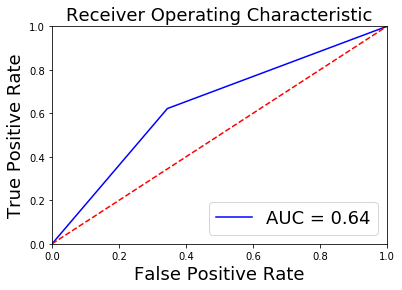

In [0]:

fpr, tpr, threshold = metrics.roc_curve(y_res_test_2, y_pred_3)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic',fontsize = 18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right',fontsize=18)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.show()

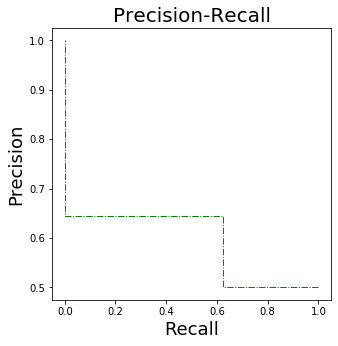

In [0]:
precision_RF, recall_RF, threshold = metrics.precision_recall_curve(y_res_test_2, y_pred_3)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.step(recall_RF, precision_RF, linestyle='-.', c='g', lw=1, where='post',
label="Decision tree ")

ax.set_title("Precision-Recall", fontsize=20)
ax.set_xlabel('Recall', fontsize=18)
ax.set_ylabel('Precision', fontsize=18)
plt.show()

Analysis using Skope rules

In [0]:
pip install skope-rules

     |████████████████████████████████| 2.0MB 3.4MB/s 
  Created wheel for skope-rules: filename=skope_rules-1.0.0-cp36-none-any.whl size=14591 sha256=95977d5c4121c389d9a5b5d4afde75545be5b577532093eb4824816d8e8bb5d6
  Stored in directory: /root/.cache/pip/wheels/3e/8d/56/464f328ff3200c785626967ee39a6b2efc455469dab615f03e
Successfully built skope-rules


In [0]:
from skrules import SkopeRules
from sklearn.metrics import roc_curve, precision_recall_curve
features =  ['Number_of_Vehicles','Number_of_Casualties', 
            'Day_of_Week','First_Road_Class', 'Road_Type', 'Speed_limit', 'Light_Conditions', 
            'Weather_Conditions','Road_Surface_Conditions', 'Special_Conditions_at_Site',
            'Carriageway_Hazards', 'Urban_or_Rural_Area',
            'Vehicle_Type', 'Vehicle_Manoeuvre', 'Skidding_and_Overturning',
            'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
            'First_Point_of_Impact', 'Engine_Capacity_(CC)', 'Propulsion_Code',
            'Age_of_Vehicle', 'Sex_of_Driver', 'Age_Band_of_Driver']
clf = SkopeRules( random_state= 42, n_estimators=5,
feature_names=features, recall_min=0.01, precision_min=0.5)

clf.fit(X_res_train_2, y_res_train_2)

SkopeRules(bootstrap=False, bootstrap_features=False,
           feature_names=['Number_of_Vehicles', 'Number_of_Casualties',
                          'Day_of_Week', 'First_Road_Class', 'Road_Type',
                          'Speed_limit', 'Light_Conditions',
                          'Weather_Conditions', 'Road_Surface_Conditions',
                          'Special_Conditions_at_Site', 'Carriageway_Hazards',
                          'Urban_or_Rural_Area', 'Vehicle_Type',
                          'Vehicle_Manoeuvre', 'Skidd...
                          'Hit_Object_off_Carriageway', 'First_Point_of_Impact',
                          'Engine_Capacity_(CC)', 'Propulsion_Code',
                          'Age_of_Vehicle', 'Sex_of_Driver',
                          'Age_Band_of_Driver'],
           max_depth=3, max_depth_duplication=None, max_features=1.0,
           max_samples=0.8, max_samples_features=1.0, min_samples_split=2,
           n_estimators=5, n_jobs=1, precision_min=0.5, ra

In [0]:
y_score = clf.score_top_rules(X_res_test_2)
print(str(len(clf.rules_)) + ' rules have been built.')
for rule in clf.rules_[:6]:
  print(rule[0])

5 rules have been built.
First_Point_of_Impact > 0.5 and Number_of_Casualties <= 2.5 and Number_of_Vehicles > 1.5
First_Point_of_Impact > 0.5 and Number_of_Casualties <= 2.5 and Vehicle_Type <= 4.5
First_Point_of_Impact <= 0.5 and Number_of_Vehicles > 1.5 and Speed_limit <= 55.0
First_Point_of_Impact <= 0.5 and Number_of_Casualties <= 4.5 and Speed_limit > 55.0
First_Point_of_Impact <= 0.5 and Number_of_Casualties <= 3.5 and Speed_limit > 55.0


In [0]:
print(clf.rules_)

[('First_Point_of_Impact > 0.5 and Number_of_Casualties <= 2.5 and Number_of_Vehicles > 1.5', (0.5400665755370426, 0.5259775478973596, 8)), ('First_Point_of_Impact > 0.5 and Number_of_Casualties <= 2.5 and Vehicle_Type <= 4.5', (0.5421927143710261, 0.5208022620983797, 2)), ('First_Point_of_Impact <= 0.5 and Number_of_Vehicles > 1.5 and Speed_limit <= 55.0', (0.796202763984627, 0.1662382920023737, 10)), ('First_Point_of_Impact <= 0.5 and Number_of_Casualties <= 4.5 and Speed_limit > 55.0', (0.640351338769317, 0.07431437473982294, 8)), ('First_Point_of_Impact <= 0.5 and Number_of_Casualties <= 3.5 and Speed_limit > 55.0', (0.654196157735086, 0.06990815775256617, 2))]


In [0]:
feat_cols = ['feature'+str(i) for i in range(X_res_test_2.shape[1])]
normalised_df = pd.DataFrame(X_res_test_2,columns=feat_cols)
normalised_df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22
0,4,3,0,0,3,60,4,1,0,3,1,0,14,3,2,6,5,0,1997,5,1,1,6
1,2,1,4,2,3,30,4,1,0,3,1,1,11,11,4,6,5,1,124,8,10,1,2
2,1,1,1,0,1,30,4,1,4,3,1,1,14,4,2,6,5,2,2295,8,2,1,6
3,3,7,3,2,3,60,4,1,4,3,1,0,2,11,2,6,5,1,1997,5,7,1,7
4,4,4,3,0,3,30,4,1,0,3,1,0,2,3,2,6,5,4,1398,5,13,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182763,2,2,1,2,3,60,4,1,0,3,1,0,2,3,2,6,5,0,2188,5,4,0,5
182764,2,1,6,2,2,30,4,1,0,3,1,1,10,3,2,6,5,1,125,8,1,1,4
182765,2,2,0,4,0,70,4,1,0,3,1,1,12,7,2,6,5,1,599,8,4,1,3
182766,3,2,3,4,0,70,1,1,4,3,1,0,2,3,4,6,5,2,1229,8,2,1,3


In [0]:
normalised_df['accident_class_severity'] = y_res_test_2

Testing Rule 1

In [0]:
y = normalised_df[(normalised_df['feature17'] > 0)&(normalised_df['feature1'] <= 2)&(normalised_df['feature0'] > 1) ].accident_class_severity

In [0]:
print(Counter(y))

Counter({1: 48040, 0: 40980})


In [0]:
df_uk['1st_Point_of_Impact'].unique()

array(['Front', 'Back', 'Offside', 'Nearside', 0.0], dtype=object)

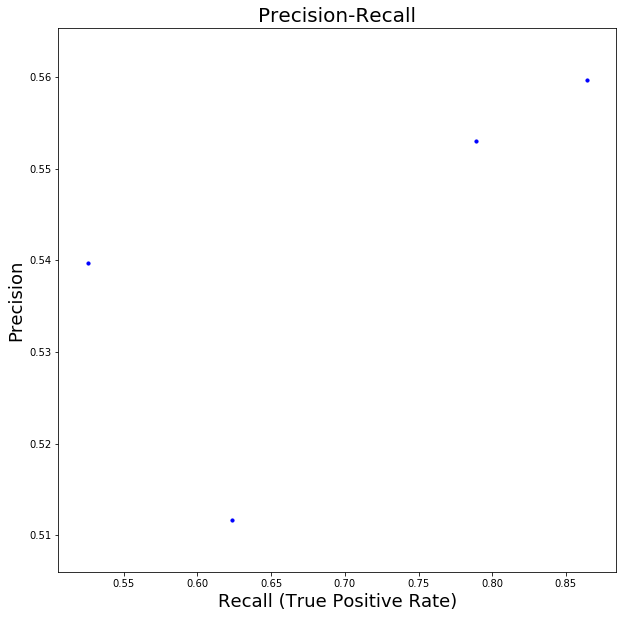

In [0]:
precision, recall, _ = precision_recall_curve(y_res_test_2, y_score)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.scatter(recall[1:-1], precision[1:-1], c='b', s=10,
label="rules of SkopeRules")
ax.set_title("Precision-Recall", fontsize=20)
ax.set_xlabel('Recall (True Positive Rate)', fontsize=18)
ax.set_ylabel('Precision', fontsize=18)
plt.show()